In [1]:
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from storage_utils.patients_data_new import patients
import os
from biosppy.signals import ecg


/home/franciscosargo/.virtualenvs/pre_epi_seizures/local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def detect_rpeaks(feature_signal, detector, sampling_rate):
    # detect rpeaks
    rpeaks = detector(signal=feature_signal,
                      sampling_rate=sampling_rate)['rpeaks']
    return rpeaks

In [3]:
# Open data file
# load the file

disk='/mnt/Seagate/'
files_dir = 'h5_files_backup/processing_datasets/'
file_name = 'seizure_datasets_new.h5'
file_path = disk + files_dir + file_name
print file_path
f = h5py.File(file_path, 'r')


/mnt/Seagate/h5_files_backup/processing_datasets/seizure_datasets_new.h5


In [4]:
# Get Filtered and Detrended signal

# patient parameters
patient_nr=3
patient_info = patients[str(patient_nr)]
patient_info

# feature for analysis
feature_name=('signals/3000_1200'
              '/raw'
              '/baseline_removal__filt:MedianFIR')


def get_seizure_feature_from_patient(f,
                                     feature_name,
                                     patient_number
                                     channel_number):

    seizures = f[feature_name].keys()

    # get seizures from patient
    seizure_from_patient = [seizure
                             for seizure in seizures
                             if seizure.split('_')[0] == str(patient_number)]
    print seizure_from_patient


    # Example for one seizure
    seizure_name = seizure_from_patient[seizure_number]

    patient_info

    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # Create a list of types of seizure to join --Change! This depends on the patient
    types_of_seizure = patient_info['types_of_seizure'] + patient_info['types_of_seizure']


    print types_of_seizure

    type_of_seizure = types_of_seizure[0]


    # Get the time parameters of the signal
    Fs=1000
    sec_before_onset = 50 * 60
    sec_after_onset = 20 * 60
    time_seconds = np.linspace(-sec_before_onset, sec_after_onset, 
                               (sec_before_onset + sec_after_onset) * Fs)

    # get the hdf5 dataset
    seizure_hdfdataset = f[feature_name + '/' + seizure_name]

    # load the array to memory
    seizure_array = seizure_hdfdataset[:]

# Load the array into unidimensional signal, since it is unidimensional ECG
medianFIR_ecg = seizure_array[0]


    

signals/3000_1200/raw/baseline_removal__filt:MedianFIR
[u'3_FA7774DK_ECG-_2017-04-20 07:38:44.000000_0', u'3_FA7774DK_Ecg_2017-04-20 07:38:44.000000_0', u'3_FA7774DR_ECG-_2017-04-20 16:09:45.000000_1', u'3_FA7774DR_Ecg_2017-04-20 16:09:45.000000_1', u'3_FA7774DT_ECG-_2017-04-20 20:10:11.000000_2', u'3_FA7774DT_Ecg_2017-04-20 20:10:11.000000_2']
['G-A-M', 'F-NA-M', 'F-A-M', 'G-A-M', 'F-NA-M', 'F-A-M']


In [5]:
# Detect rpeaks
rpeaks = ecg.hamilton_segmenter(signal=medianFIR_ecg,
                                sampling_rate=1000)['rpeaks']

In [6]:
# Set path to save
path_to_save = '/home/franciscosargo/final_results/PATIENT{}/rpeak_detection/hamilton'.format(patient_nr) 
if not os.path.exists(path_to_save):
    print 'File doesnt exist'
    os.makedirs(path_to_save)

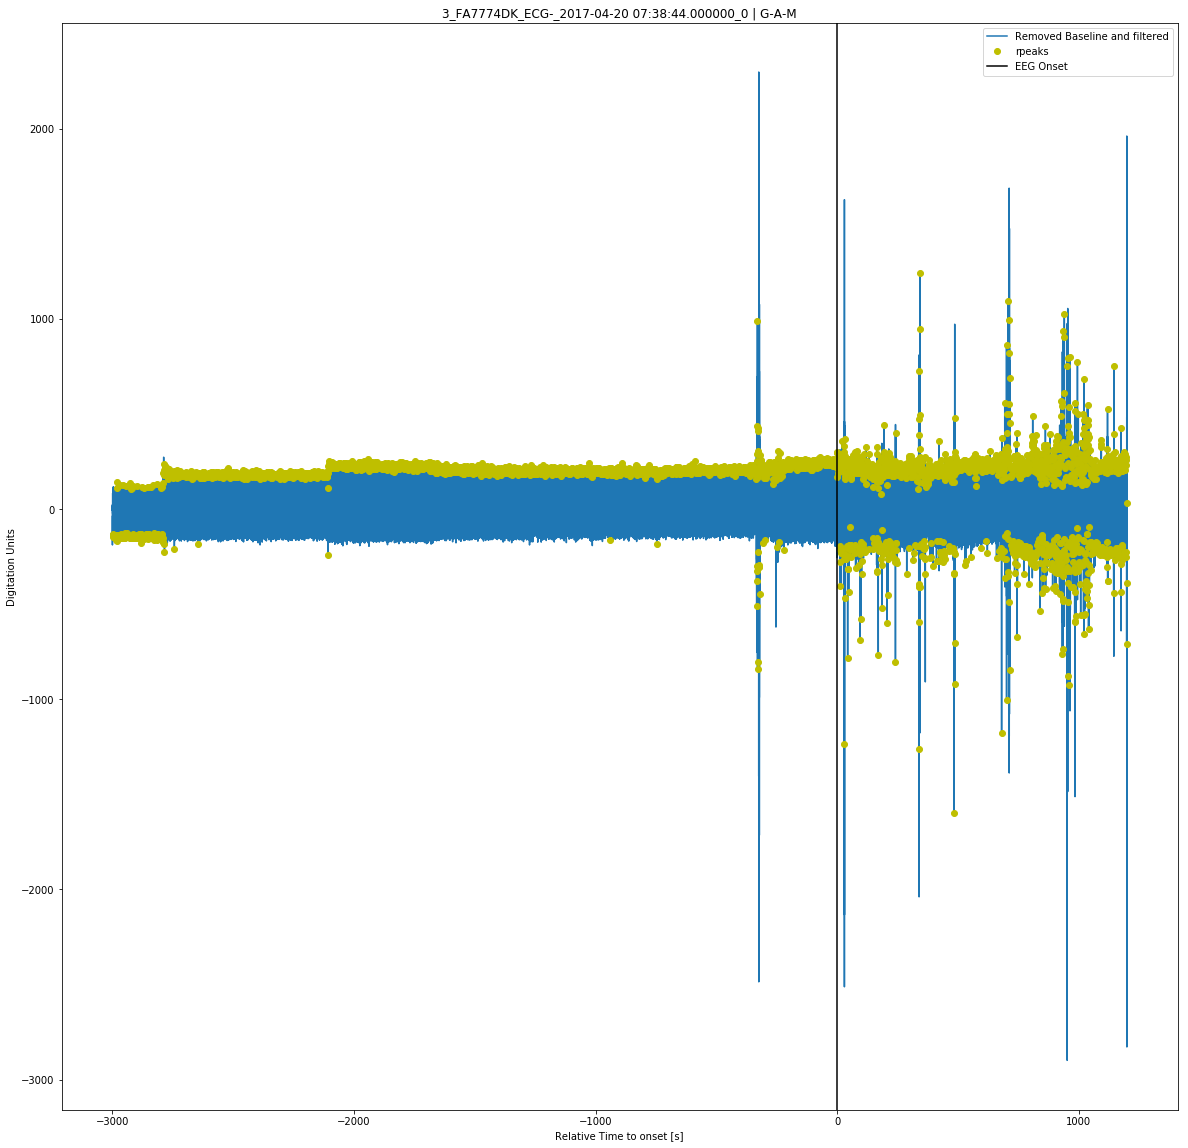

In [7]:
# Plot Entire Acquisition --Ilustrative purposes
seizure_features=['Removed Baseline and filtered']

# Get the time parameters of the signal
Fs=1000
sec_before_onset = 50 * 60
sec_after_onset = 20 * 60
relative_time_seconds = np.linspace(-sec_before_onset, sec_after_onset, 
                           (sec_before_onset + sec_after_onset) * Fs)   # relative time-frame to EEG onset
time_sec = np.linspace(0, (sec_before_onset + sec_after_onset),
                           (sec_before_onset + sec_after_onset) * Fs)   # time-frame relative
                                                                        # to the beggining of acquisition

# Plot the signal
plt.figure(figsize=(20, 20))
plt.plot(relative_time_seconds, medianFIR_ecg.T)
plt.plot(relative_time_seconds[rpeaks], medianFIR_ecg.T[rpeaks], 'yo')
plt.axvline(x=0, c='k')
plt.legend([seizure_features[0], 'rpeaks', 'EEG Onset'])
plt.xlabel('Relative Time to onset [s]')
plt.ylabel('Digitation Units')

plt.title(seizure_name + ' ' + '|' + ' ' + type_of_seizure)
plt.show() 

# Get seizure id
seizure_id = seizure_name.split('_')
lead_name = seizure_id[2]
seizure_nr = seizure_id[-1]
patient_nr = seizure_id[0]


In [8]:
# Load the other lead ECG


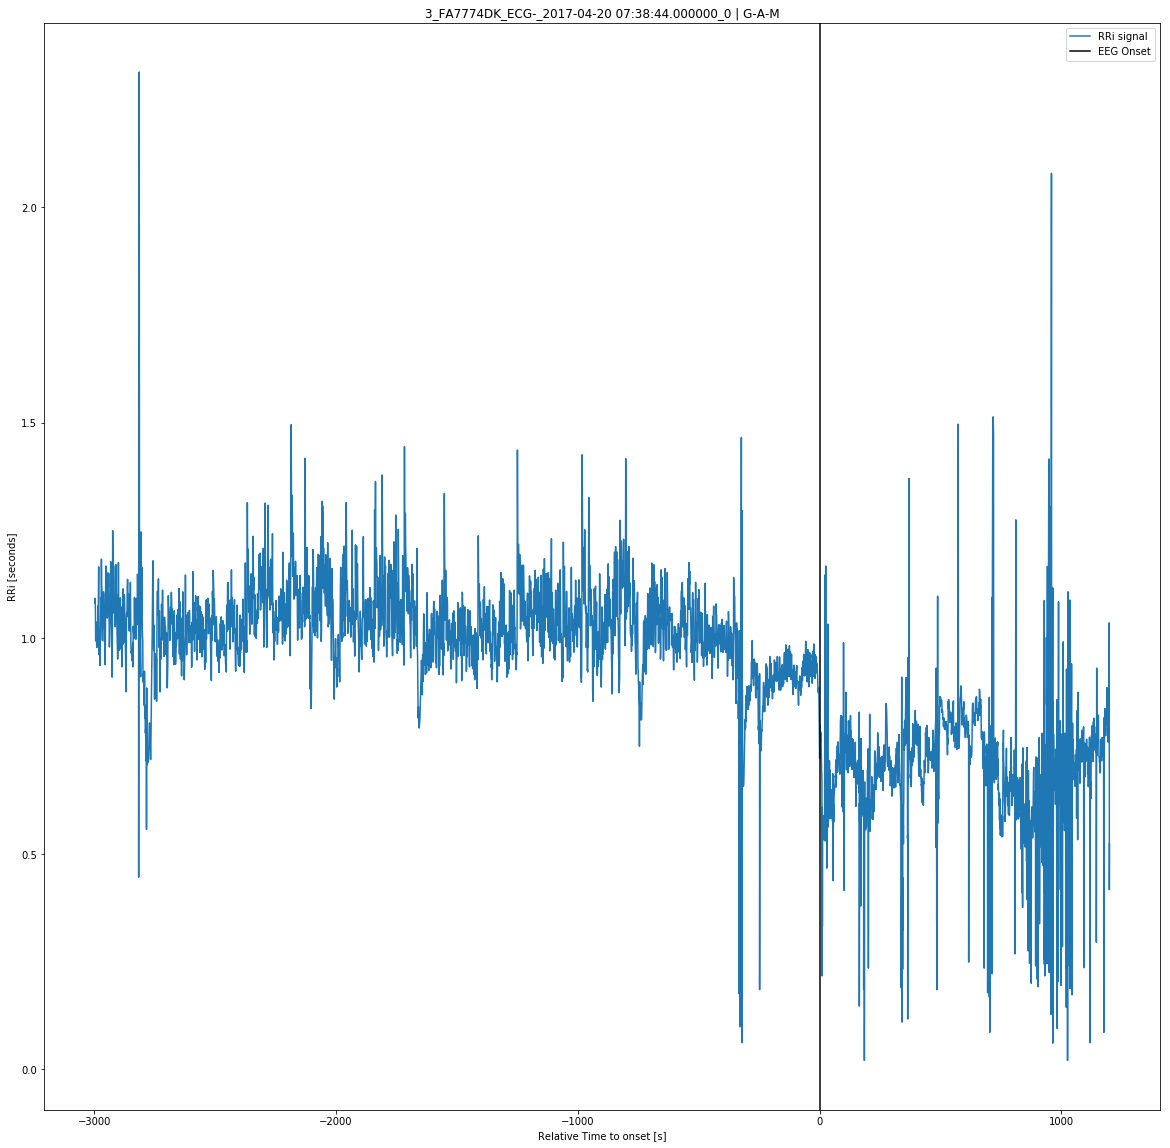

In [9]:
# compute rr-tachogram

time_rpeaks = time_sec[rpeaks]
rri = np.diff(time_rpeaks)
time_sec_rri = time_rpeaks[1:]
relative_time_sec_rri = relative_time_seconds[rpeaks][1:]

# Plot the signal
plt.figure(figsize=(20, 20))
plt.plot(relative_time_sec_rri, rri)

plt.axvline(x=0, c='k')
plt.legend(['RRi signal', 'EEG Onset'])
plt.xlabel('Relative Time to onset [s]')
plt.ylabel('RRi [seconds]')
plt.title(seizure_name + ' ' + '|' + ' ' + type_of_seizure)
plt.show() 

In [10]:
from scipy.interpolate import interp1d
from scipy.signal import upfirdn
#from scipy.signal import sinc
import matlab

time_window_flag = False

if time_window_flag==True:

    # Get window of the signal - 3min --for INTERPOLATION and resampling
    win = 3 * 60
    low = 47 * 60
    up = low + win

    # Get interpolation function --full domain of RRi and ECG signal
    f_rri = interp1d(x=time_sec_rri, y=rri)

    # Get a window of the time samples, plus elemt for interpolation
    time_sec_bool = np.where(np.logical_and(time_sec>=low, time_sec<=up))
    time_sec_rri_bool = np.where(np.logical_and(time_sec_rri>=low, time_sec_rri<=up))
    time_rpeaks_bool = np.where(np.logical_and(time_rpeaks>=low, time_rpeaks<=up))

    # Get ECG signal filtered and detrended
    time_window_sec = time_seconds[time_sec_bool]
    medianFIR_ecg_window = medianFIR_ecg_array[time_sec_bool]

    # Get R-peaks
    time_rpeaks_window = time_rpeaks[time_rpeaks_bool]
    rpeaks_window = rpeaks[time_rpeaks_bool]

    # Get RRi signal
    time_window_sec_rri = time_sec_rri[time_sec_rri_bool]
    rri_window = rri[time_sec_rri_bool]


    new_fs_list = [10, 1000]  # New factor up

    plt.figure(figsize=(20, 15))

    for i, new_fs in enumerate(new_fs_list):

        # Get new domain array --which the limits must be the window's
        num=new_fs*len(time_window_sec_rri)
        #new_domain = np.linspace(0, up, num)

        # Resampling zero-pad FIR method, details in references

        h = sinc
        resampled_rri = scipy.signal.upfirdn()


       # new_domain = np.linspace(time_window_sec_rri[0],
            #                     time_window_sec_rri[-1],
            #                     num)

        # Cubic spline method
        f = interp1d(time_window_sec_rri,
                    rri_window,
                    kind='cubic')
        resampled_rri_window_cubic = f(new_domain)


        print '------------'
        print 'This is the length of the signals'
        print 'Resampled RRi zero-pad FIR '
        print resampled_rri_window_fourrier
        print len(resampled_rri_window_fourrier)

        print '------------'
        print 'This is the length of the signals'
        print 'Resampled RRi win cubic'
        print resampled_rri_window_cubic
        print len(resampled_rri_window_cubic)

        # Estimate Power spectral Density

        # Periofograms
        rrwf_f, rrwf_psd_periodogram = periodogram(resampled_rri_window_fourrier,
                                           fs=new_fs)
        rrwc_f, rrwc_psd_periodogram = periodogram(resampled_rri_window_cubic,
                                           fs=new_fs)

        print len(rrwf_f)
        print len(rrwc_f)



        plt.subplot(2, 2, i+1)
        plt.plot(time_sec_rri[time_window_bool], rri_window,'ko-')
        plt.plot(time_resampled_rri, resampled_rri_window_fourrier ,'bo')
        #plt.plot(new_domain, resampled_rri_window_cubic, 'g')
        plt.ylabel('RRi [s]')
        plt.xlabel('Time [s]')
        plt.legend(['Raw',
                    'Resampled - zero-filling - {}  - {}Hz'.format(new_fs),
                    'Cubic Spline Interpolation'])
        plt.title('3 min before EEG onset')


        plt.subplot(2, 2, (i+3))
        plt.plot(rrwf_f, rrwf_psd_periodogram ,'b')
        #plt.plot(rrwc_f, rrwc_psd_periodogram, 'g')
        plt.xlabel('frequency [Hz]')
        plt.ylabel('PSD [V**2/Hz]')
        plt.legend(['Resampled - zero-filling - {} - {}Hz'.format(new_fs),
                    'Cubic Spline Interpolation'])
        plt.xlim(0, 0.5)

    plt.show()

In [11]:
import scipy.signal as signal

#Plot frequency and phase response
def mfreqz(b,a=1):
    w,h = signal.freqz(b,a)
    h_dB = 20 * log10 (abs(h))
    subplot(211)
    plot(w/max(w),h_dB)
    ylim(-150, 5)
    ylabel('Magnitude (db)')
    xlabel(r'Normalized Frequency (x$\pi$rad/sample)')
    title(r'Frequency response')
    subplot(212)
    h_Phase = unwrap(arctan2(imag(h),real(h)))
    plot(w/max(w),h_Phase)
    ylabel('Phase (radians)')
    xlabel(r'Normalized Frequency (x$\pi$rad/sample)')
    title(r'Phase response')
    subplots_adjust(hspace=0.5)

#Plot step and impulse response
def impz(b,a=1):
    l = len(b)
    impulse = repeat(0.,l); impulse[0] =1.
    x = arange(0,l)
    response = signal.lfilter(b,a,impulse)
    subplot(211)
    stem(x, response)
    ylabel('Amplitude')
    xlabel(r'n (samples)')
    title(r'Impulse response')
    subplot(212)
    step = cumsum(response)
    stem(x, step)
    ylabel('Amplitude')
    xlabel(r'n (samples)')
    title(r'Step response')
    subplots_adjust(hspace=0.5)

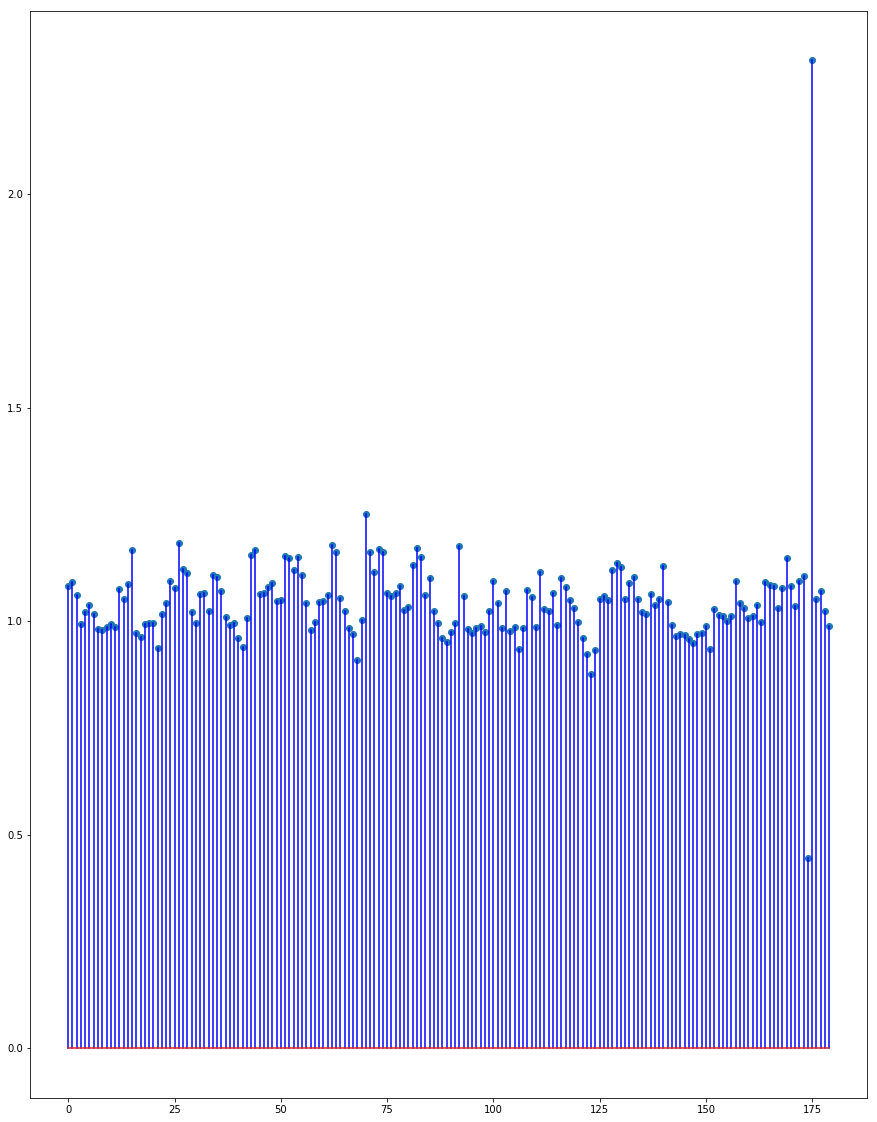

In [12]:
# Get arrays for rri analysis

# DO NOT FORGET RAW

samples_window_flag = True

if samples_window_flag==True:
    
    # get structure of window for rri signal 
    n_samples = 180
    low = 0
    up = low + n_samples
    
    # Get RRi signal
    samples_window_time_sec_rri = time_sec_rri[low:up]
    samples_window_rri = rri[low:up]
    

    
plt.figure(figsize=(15,20))
plt.stem(samples_window_rri, 'b-')
plt.show()

In [13]:
# Resample RRi signal
from scipy.signal import resample_poly, resample, firwin, firls, upfirdn
from pylab import *


# ideal interpolation (sinc)
M=4  # M is equal to 2 (number of samples non-zero used for interpolation)
L=10  # order of interpolation
alpha=0.3  # percentage of Nyquist Frequency (cutoff)

# Get filter coefficients
# simple design using windowed sinc function
h = np.sinc(alpha * (np.pi / L) * np.linspace(-M*
                                              L, M*L, 2*M*L + 1))

# Use least squares minization to obtain frequency response
Fs = 1  # approximate sampling rate
numtaps = 2 * M * L - 1  # order of the filter, mimicking an idealized truncated sinc FIR
bands = [alpha * 0.5, 0.5]
desired = [L, 0]
b = firls(numtaps=numtaps, bands=bands, desired=desired, nyq=0.5)

# resample - direct fourier method (non-polyphasic)
resample_rri_window = resample(x=samples_window_rri, num=L*n_samples, axis=0, window=None)

# resample - polyphasic zero_padding_method??
resamp_poly_rri_window = resample_poly(x=samples_window_rri, up=L, down=1, window=b)

# upfirdn - zero_padding upsampling, FIR interpolator with alpha cut-off
upfirdn_rri_window = upfirdn(h=b, x=samples_window_rri, up=L, down=1, axis=-1)






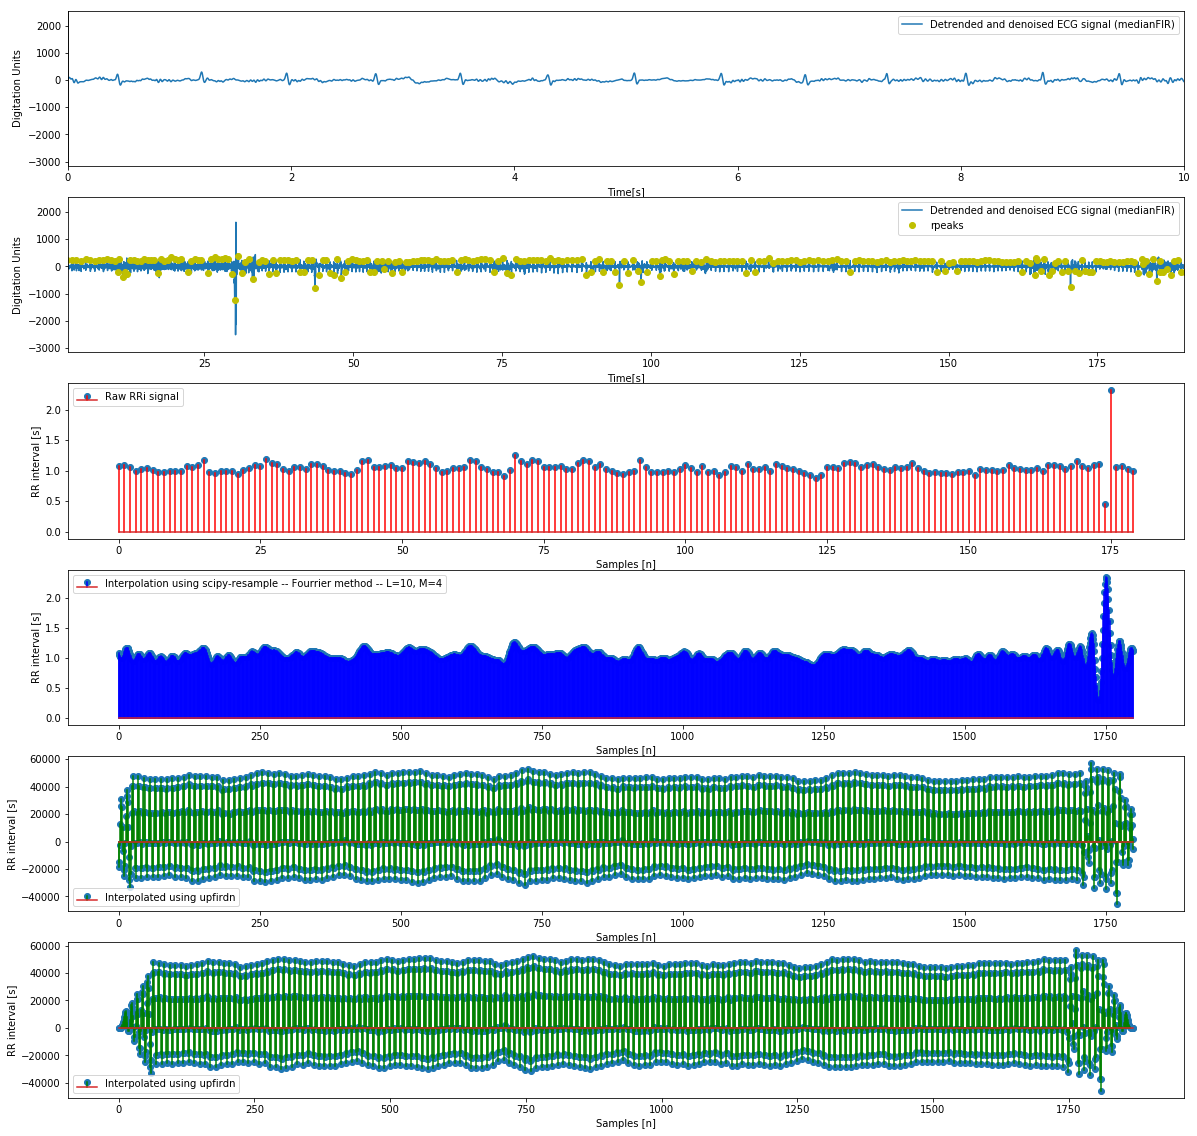

In [23]:
plt.figure(figsize=(20,20))

plt.subplot(611)
plt.plot(relative_time_seconds, medianFIR_ecg.T)
plt.axvline(x=0, c='k')
plt.xlim([0, 10])
plt.xlabel('Time[s]')
plt.ylabel('Digitation Units')
plt.legend(['Detrended and denoised ECG signal (medianFIR)'])

plt.subplot(612)
plt.plot(relative_time_seconds, medianFIR_ecg.T)
plt.plot(relative_time_seconds[rpeaks], medianFIR_ecg.T[rpeaks], 'yo')
plt.axvline(x=0, c='k')
plt.xlim([samples_window_time_sec_rri[0], samples_window_time_sec_rri[-1]])
plt.xlabel('Time[s]')
plt.ylabel('Digitation Units')
plt.legend(['Detrended and denoised ECG signal (medianFIR)', 'rpeaks'])

plt.subplot(613)
plt.stem(samples_window_rri, 'r')
plt.xlabel('Samples [n]')
plt.ylabel('RR interval [s]')
plt.legend(['Raw RRi signal'])

plt.subplot(614)
plt.stem(resample_rri_window, 'b')
plt.xlabel('Samples [n]')
plt.ylabel('RR interval [s]')
plt.legend(['Interpolation using scipy-resample -- Fourrier method -- L={}, M={}'.format(L, M)])

plt.subplot(615)
plt.stem(resamp_poly_rri_window, 'g')
plt.xlabel('Samples [n]')
plt.ylabel('RR interval [s]')
plt.legend(['Interpolated using upfirdn'])

plt.subplot(616)
plt.stem(upfirdn_rri_window, 'g')
plt.legend(['Interpolated using upfirdn'])
plt.xlabel('Samples [n]')
plt.ylabel('RR interval [s]')
plt.show()

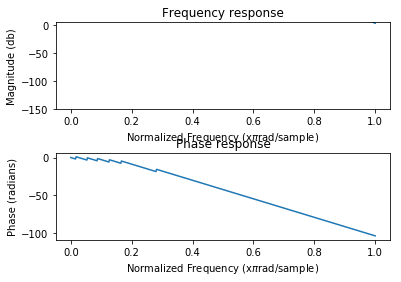

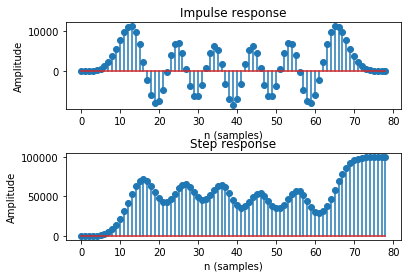

In [15]:
# Plot the frequency response of the 'ls' interpolation filter 

plt.figure()
mfreqz(b)
plt.show()

plt.figure()
impz(b)
plt.show()



In [16]:
# Using the Fourrier Method
a = np.array([1, 2, 3, 4])
a[0:2]


array([1, 2])